In [33]:
from importlib import reload
from itertools import chain

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from evaluation import evaluator

reload(evaluator)

<module 'evaluation.evaluator' from '/home/alex/code/ML/ML24/exercise-1/evaluation/evaluator.py'>

# Preprocessing

In [34]:
data = arff.loadarff('./datasets/credit-g/dataset_31_credit-g.arff')
data = pd.DataFrame(data[0])

for column in data.columns:
    # replace missing values with pd.NA
    data[column] = data[column].replace(b'?', pd.NA)
    data[column] = data[column].replace(b'', pd.NA)
    data[column] = data[column].replace(b'NONE', pd.NA)
    # decode bytes to string for each column
    data[column] = data[column].apply(lambda x: x.decode() if isinstance(x, bytes) else x)

In [35]:
data

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,...,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes,good
996,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,...,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
997,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,...,car,38.0,none,own,1.0,skilled,1.0,none,yes,good
998,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,...,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes,bad


In [36]:
y = data[('class')] 
X = data.drop('class', axis=1)  # Features


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
print("null values in train data: "+ str(X_train.isnull().sum().sum()))
print("null values in test data: "+ str(X_test.isnull().sum().sum()))

null values in train data: 0
null values in test data: 0


In [38]:
# find all numerical columns in X_train
numerical_columns = X_train.select_dtypes(include="number").columns
# convert numerical columns to list
numerical_columns = numerical_columns.tolist()
numerical_columns

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [39]:
feature_mappings = {
    'checking_status': ['no checking', '<0', '0<=X<200', '>=200'],
    'saving_status': ['no known savings', '<100', '100<=X<500', '500<=X<1000', '>=1000'],
    'employment': ['unemployed', '<1', '1<=X<4', '4<=X<7', '>=7'],
    'own_telephone': ['none', 'yes'],
    'foreign_worker': ['no', 'yes'],
}

ordinal_columns = [col for col in X_train.columns if col in feature_mappings.keys()]
ordinal_categories = [feature_mappings[col] for col in ordinal_columns]
ordinal_columns

['checking_status', 'employment', 'own_telephone', 'foreign_worker']

In [40]:
categorical_columns = [col for col in X_train.columns if col not in ordinal_columns and col not in numerical_columns] 

one_hot_encoding_limit = 10
one_hot_columns = [col for col in categorical_columns if X_train[col].nunique() <= one_hot_encoding_limit]

label_columns = [col for col in categorical_columns if col not in one_hot_columns]

In [41]:
preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_columns),
    ('categorical', OneHotEncoder(handle_unknown="ignore"), one_hot_columns),
    ('label', OrdinalEncoder(), label_columns)
],
    remainder='passthrough'  # passthrough columns not listed in any pipeline
)

In [42]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())
])

pipeline_standard = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

X_train_std = pipeline_standard.fit_transform(X_train)
X_test_std = pipeline_standard.transform(X_test)

# Preprocess training data
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [43]:
# Encode target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Evaluation

## Neural Network

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 5000, 'verbose': False}
done with  hidden_layer_sizes   (7,)
done with  hidden_layer_sizes   (7, 7)
done with  hidden_layer_sizes   (7, 7, 7)
done with  hidden_layer_sizes   (7, 7, 7, 7)


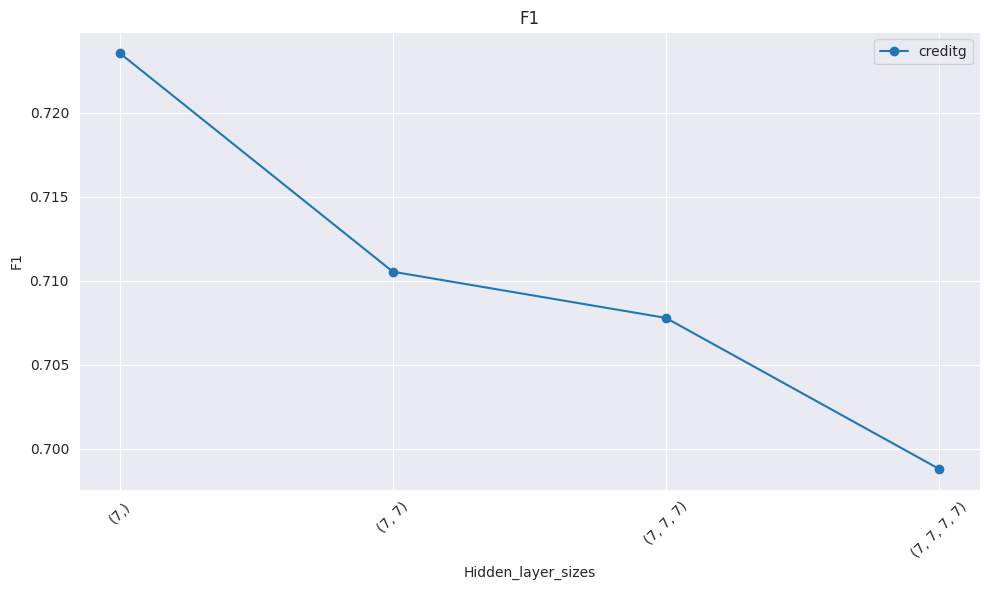

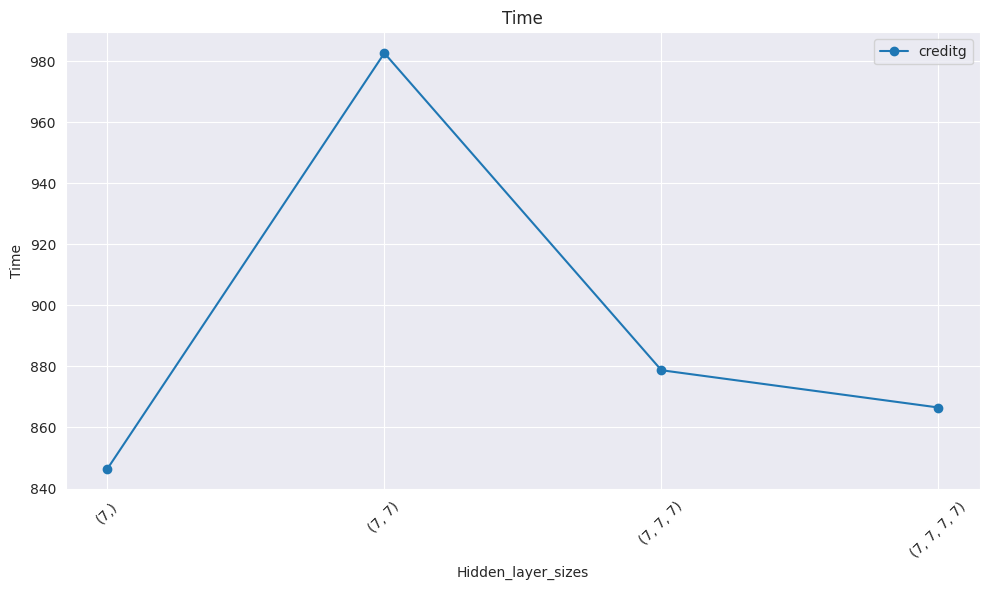

In [27]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    #'hidden_layer_sizes': (15, 15, 15),
    #'random_state': 7895,
    'max_iter': 5000,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'hidden_layer_sizes': [(7, ), (7, 7), (7, 7, 7), (7, 7, 7, 7),]}
nn_hidden_layer_deepness = evaluator.evaluate2_mean(MLPClassifier, X_train_std, y_train, X_test_std, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=10)
evaluator.draw_diagram2_list({"creditg": nn_hidden_layer_deepness}, x_axis='hidden_layer_sizes', y_axis=['f1', 'time'], logaritmic=False)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 5000, 'verbose': False}
done with  hidden_layer_sizes   (1, 1)  results:  {'accuracy': 0.708, 'recall': 0.708, 'precision': 0.5819859284627092, 'f1': 0.6341014228177286, 'time': 779.4164180755615, 'hidden_layer_sizes': (1, 1)}
done with  hidden_layer_sizes   (2, 2)  results:  {'accuracy': 0.701, 'recall': 0.701, 'precision': 0.6137351366440413, 'f1': 0.6496190401920117, 'time': 276.0833740234375, 'hidden_layer_sizes': (2, 2)}
done with  hidden_layer_sizes   (3, 3)  results:  {'accuracy': 0.74, 'recall': 0.74, 'precision': 0.7367901059215114, 'f1': 0.7371950840880859, 'time': 500.1332759857178, 'hidden_layer_sizes': (3, 3)}
done with  hidden_layer_sizes   (4, 4)  results:  {'accuracy': 0.709, 'recall': 0.7090000000000001, 'precision': 0.7018505215199639, 'f1': 0.7039895777379954, 'time': 543.6022281646729, 'hidden_layer_sizes': (4, 4)}
done with  hidd

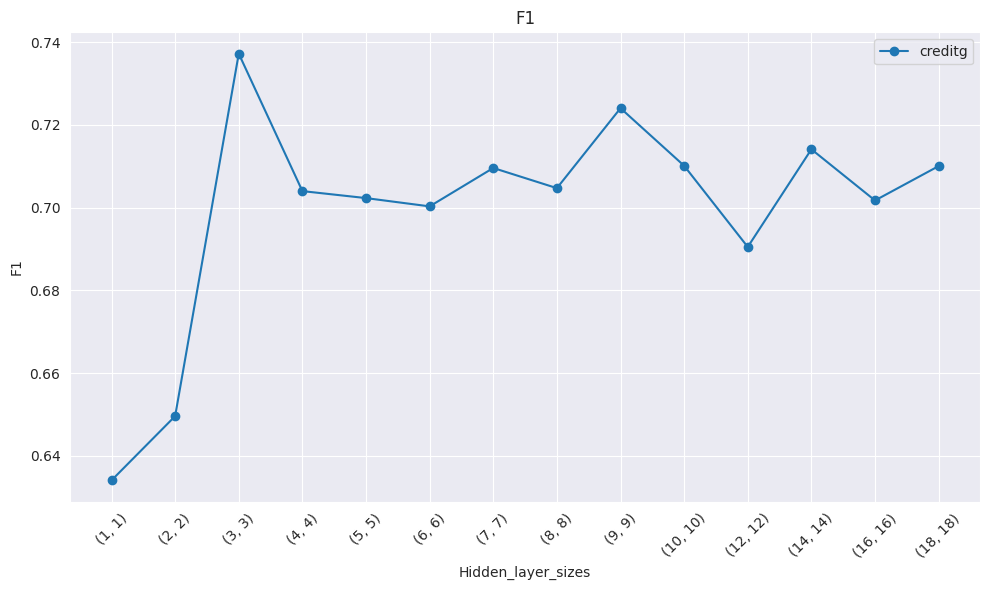

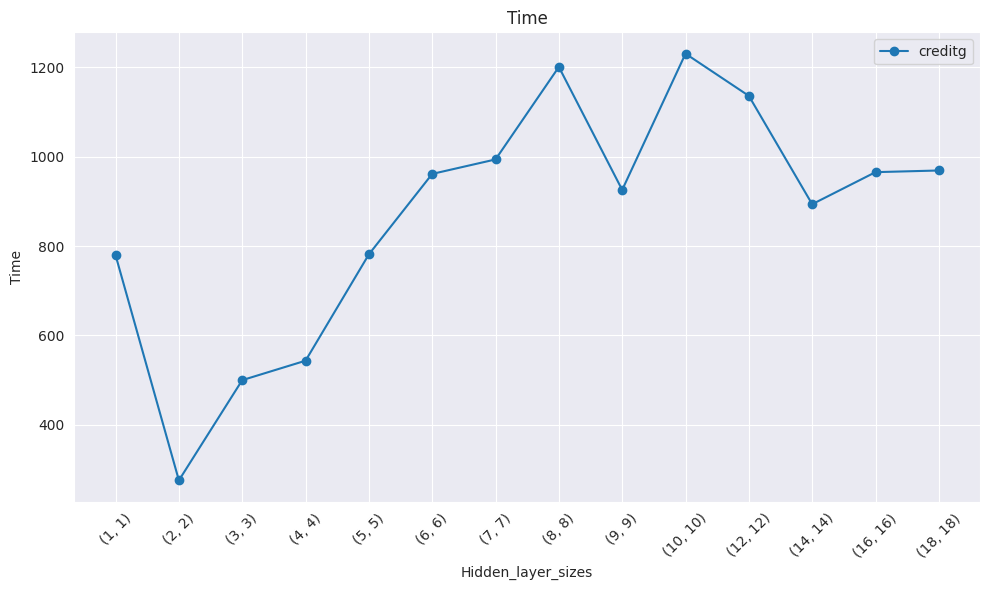

In [29]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    #'hidden_layer_sizes': (15, 15, 15),
    #'random_state': 7895,
    'max_iter': 5000,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'hidden_layer_sizes': [(i, i) for i in chain(range(1, 10, 1), range(10, 20, 2))]}
nn_hidden_layer = evaluator.evaluate2_mean(MLPClassifier, X_train_std, y_train, X_test_std, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=5)
evaluator.draw_diagram2_list({"creditg": nn_hidden_layer}, x_axis='hidden_layer_sizes', y_axis=['f1', 'time'], logaritmic=False)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'hidden_layer_sizes': (7,), 'max_iter': 1500, 'verbose': False}
done with  learning_rate_init   1e-06  results:  {'accuracy': 0.45599999999999996, 'recall': 0.45600000000000007, 'precision': 0.4788032686982893, 'f1': 0.34771020335474245, 'time': 6.665706634521484, 'learning_rate_init': 1e-06}
done with  learning_rate_init   1.4030037231905748e-06  results:  {'accuracy': 0.562, 'recall': 0.562, 'precision': 0.5338009295034016, 'f1': 0.49156794614031585, 'time': 6.630373001098633, 'learning_rate_init': 1.4030037231905748e-06}
done with  learning_rate_init   1.9684194472866114e-06  results:  {'accuracy': 0.607, 'recall': 0.607, 'precision': 0.560813781124228, 'f1': 0.5400209694759412, 'time': 6.899356842041016, 'learning_rate_init': 1.9684194472866114e-06}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   2.761699813343849e-06  results:  {'accuracy': 0.446, 'recall': 0.446, 'precision': 0.3824384219225396, 'f1': 0.3592969318555872, 'time': 180.6966781616211, 'learning_rate_init': 2.761699813343849e-06}
done with  learning_rate_init   3.874675120456128e-06  results:  {'accuracy': 0.5559999999999999, 'recall': 0.5559999999999999, 'precision': 0.4672984501414799, 'f1': 0.4867478730069494, 'time': 14.802837371826172, 'learning_rate_init': 3.874675120456128e-06}
done with  learning_rate_init   5.436183620153837e-06  results:  {'accuracy': 0.571, 'recall': 0.5710000000000001, 'precision': 0.60184512415569, 'f1': 0.570384677583603, 'time': 92.18287467956543, 'learning_rate_init': 5.436183620153837e-06}
done with  learning_rate_init   7.626985859023451e-06  results:  {'accuracy': 0.638, 'recall': 0.638, 'precision': 0.5337206761626054, 'f1': 0.5614797767700886, 'time': 118.07389259338379, 'learning_rate_init': 7.626985859023451e-06}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   1.0700689556931746e-05  results:  {'accuracy': 0.616, 'recall': 0.616, 'precision': 0.5837995508646208, 'f1': 0.5853901975731882, 'time': 377.5473117828369, 'learning_rate_init': 1.0700689556931746e-05}
done with  learning_rate_init   1.5013107289081743e-05  results:  {'accuracy': 0.665, 'recall': 0.665, 'precision': 0.537200161006207, 'f1': 0.5817157031548494, 'time': 382.39474296569824, 'learning_rate_init': 1.5013107289081743e-05}
done with  learning_rate_init   2.10634454232412e-05  results:  {'accuracy': 0.696, 'recall': 0.696, 'precision': 0.6189216686940094, 'f1': 0.5980080472426506, 'time': 313.94710540771484, 'learning_rate_init': 2.10634454232412e-05}
done with  learning_rate_init   2.9552092352028878e-05  results:  {'accuracy': 0.697, 'recall': 0.697, 'precision': 0.5486009649785866, 'f1': 0.5914258738988926, 'time': 285.40968894958496, 'learning_rate_init': 2.9552092352028878e-05}
done with  learning_rate_init   4.146169559796814e-05  results

/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   0.00031622776601683794  results:  {'accuracy': 0.738, 'recall': 0.7380000000000001, 'precision': 0.7289700624555244, 'f1': 0.7317879757990435, 'time': 503.6033630371094, 'learning_rate_init': 0.00031622776601683794}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   0.0004436687330978611  results:  {'accuracy': 0.723, 'recall': 0.7230000000000001, 'precision': 0.712184319646302, 'f1': 0.7157365832950141, 'time': 617.3841953277588, 'learning_rate_init': 0.0004436687330978611}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   0.0006224688843995446  results:  {'accuracy': 0.721, 'recall': 0.721, 'precision': 0.707617024549519, 'f1': 0.7118971150873922, 'time': 696.3655948638916, 'learning_rate_init': 0.0006224688843995446}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: 

done with  learning_rate_init   0.0008733261623828437  results:  {'accuracy': 0.72, 'recall': 0.72, 'precision': 0.7175511149145353, 'f1': 0.7182900169736641, 'time': 730.2425861358643, 'learning_rate_init': 0.0008733261623828437}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   0.0012252798573828651  results:  {'accuracy': 0.733, 'recall': 0.733, 'precision': 0.7282101373757772, 'f1': 0.7302503082180958, 'time': 736.0607624053955, 'learning_rate_init': 0.0012252798573828651}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   0.0017190722018585747  results:  {'accuracy': 0.713, 'recall': 0.713, 'precision': 0.7122369937962674, 'f1': 0.7122002217245638, 'time': 793.4317588806152, 'learning_rate_init': 0.0017190722018585747}
done with  learning_rate_init   0.002411864699640997  results:  {'accuracy': 0.727, 'recall': 0.7270000000000001, 'precision': 0.726755758276709, 'f1': 0.7265343656734411, 'time': 610.893440246582, 'learning_rate_init': 0.002411864699640997}
done with  learning_rate_init   0.003383855153428233  results:  {'accuracy': 0.7, 'recall': 0.7, 'precision': 0.700712328761972, 'f1': 0.7001993207872224, 'time': 366.0890579223633, 'learning_rate_init': 0.003383855153428233}
done with  learning_rate_init   0.004747561378997425  results:  {'accuracy': 0.727, 'recall': 0.727, 'precision': 0.7277896310450609, 'f1': 0.7266655446427749, 'time': 294.7057247161865, 'learning_rate_init': 0.004747561378997425}
done with  learning_rate_init   0.006660846290809161  results:  {'ac

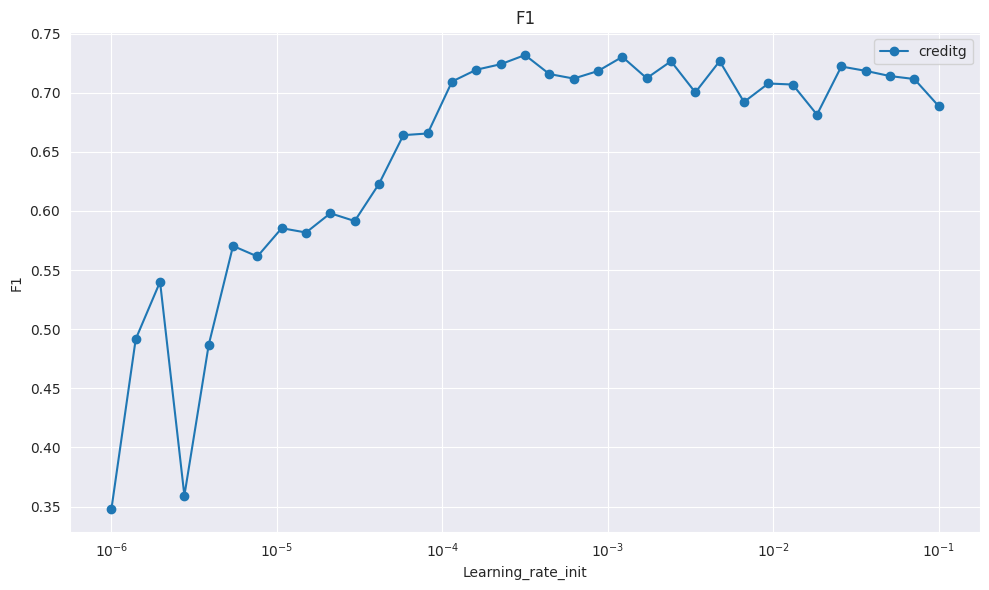

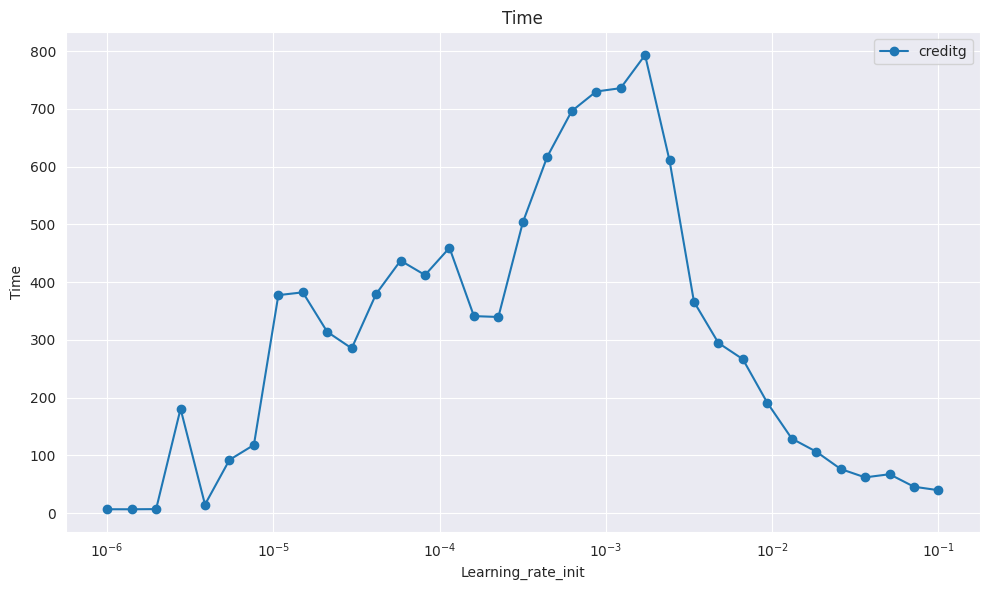

In [30]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    'hidden_layer_sizes': (7,),
    #'random_state': 7895,
    'max_iter': 1500,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'learning_rate_init': np.logspace(-6, -1, num=35)}
nn_learning_rate = evaluator.evaluate2_mean(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=5)
evaluator.draw_diagram2_list({"creditg": nn_learning_rate}, x_axis='learning_rate_init', y_axis=['f1', 'time'], logaritmic=True)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (7,), 'verbose': False}
Hyperparameter  max_iter  value:  50
Accuracy:  0.745
Recall:  0.745
Precision:  0.7294223484848484
F1:  0.7053122268252823
Time: 26.802301ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  16 |  43 |
|  1 |   8 | 133 |
+----+-----+-----+
Hyperparameter  max_iter  value:  75
Accuracy:  0.73
Recall:  0.73
Precision:  0.7047731397459165
F1:  0.6969580419580419
Time: 38.375378ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  17 |  42 |
|  1 |  12 | 129 |
+----+-----+-----+
Hyperparameter  max_iter  value:  100
Accuracy:  0.735
Recall:  0.735
Precision:  0.7119559800664451
F1:  0.7009103595167272
Time: 52.636147ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  17 |  42 |
|  1 |  11 | 

/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stoch

Hyperparameter  max_iter  value:  150
Accuracy:  0.725
Recall:  0.725
Precision:  0.7026559454191034
F1:  0.7047616617331838
Time: 90.978384ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  21 |  38 |
|  1 |  17 | 124 |
+----+-----+-----+
Hyperparameter  max_iter  value:  175
Accuracy:  0.73
Recall:  0.73
Precision:  0.7161326658322903
F1:  0.7202271852137082
Time: 92.130184ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  21 | 120 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (225) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  200
Accuracy:  0.74
Recall:  0.74
Precision:  0.7224942475839853
F1:  0.7243999999999999
Time: 106.411457ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  24 |  35 |
|  1 |  17 | 124 |
+----+-----+-----+
Hyperparameter  max_iter  value:  225
Accuracy:  0.725
Recall:  0.725
Precision:  0.707736013986014
F1:  0.7119201725997842
Time: 122.186899ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  24 |  35 |
|  1 |  20 | 121 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (275) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  250
Accuracy:  0.71
Recall:  0.71
Precision:  0.6897837357428529
F1:  0.6950401368601132
Time: 135.720491ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  22 |  37 |
|  1 |  21 | 120 |
+----+-----+-----+
Hyperparameter  max_iter  value:  275
Accuracy:  0.73
Recall:  0.73
Precision:  0.7142437275985662
F1:  0.7182120582120582
Time: 147.643566ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  25 |  34 |
|  1 |  20 | 121 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (325) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  300
Accuracy:  0.76
Recall:  0.76
Precision:  0.7487859824780976
F1:  0.751313053523296
Time: 160.031796ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  18 | 123 |
+----+-----+-----+
Hyperparameter  max_iter  value:  325
Accuracy:  0.77
Recall:  0.77
Precision:  0.757889201599763
F1:  0.7581352809580209
Time: 173.843622ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  15 | 126 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  350
Accuracy:  0.72
Recall:  0.72
Precision:  0.6974486383182036
F1:  0.7007000946073794
Time: 195.085049ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  21 |  38 |
|  1 |  18 | 123 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (375) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  375
Accuracy:  0.77
Recall:  0.77
Precision:  0.7623463613633373
F1:  0.7648087774294672
Time: 200.240850ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  32 |  27 |
|  1 |  19 | 122 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  400
Accuracy:  0.725
Recall:  0.725
Precision:  0.711732456140351
F1:  0.716026602022264
Time: 209.310055ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  22 | 119 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (425) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  425
Accuracy:  0.75
Recall:  0.75
Precision:  0.7413146466640348
F1:  0.7443573667711598
Time: 231.668234ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  30 |  29 |
|  1 |  21 | 120 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  450
Accuracy:  0.755
Recall:  0.755
Precision:  0.7456999999999999
F1:  0.7486739808947318
Time: 232.580185ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  30 |  29 |
|  1 |  20 | 121 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (475) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  475
Accuracy:  0.72
Recall:  0.72
Precision:  0.72
F1:  0.72
Time: 248.207331ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  28 | 113 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  500
Accuracy:  0.71
Recall:  0.71
Precision:  0.7044576802507837
F1:  0.7069402527297264
Time: 258.280516ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (525) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  525
Accuracy:  0.725
Recall:  0.725
Precision:  0.7139
F1:  0.7178993663104134
Time: 277.792215ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  23 | 118 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (550) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  550
Accuracy:  0.75
Recall:  0.75
Precision:  0.7351873796474596
F1:  0.7371035662587182
Time: 296.892166ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  17 | 124 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (575) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  575
Accuracy:  0.735
Recall:  0.735
Precision:  0.7266138253638253
F1:  0.7298534867046977
Time: 282.877445ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  23 | 118 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  600
Accuracy:  0.755
Recall:  0.755
Precision:  0.751547619047619
F1:  0.7530938215102975
Time: 298.540115ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  23 | 118 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (625) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  625
Accuracy:  0.715
Recall:  0.715
Precision:  0.7108928571428572
F1:  0.7127826086956524
Time: 317.631483ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (650) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  650
Accuracy:  0.745
Recall:  0.745
Precision:  0.7301835664335664
F1:  0.7328714327743454
Time: 319.730043ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  18 | 123 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (675) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  675
Accuracy:  0.725
Recall:  0.725
Precision:  0.7210565476190476
F1:  0.7228604118993135
Time: 340.321779ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  30 |  29 |
|  1 |  26 | 115 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  700
Accuracy:  0.71
Recall:  0.71
Precision:  0.6943637880684189
F1:  0.6995032730073162
Time: 351.369381ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  24 |  35 |
|  1 |  23 | 118 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (725) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  725
Accuracy:  0.75
Recall:  0.75
Precision:  0.7432614555256065
F1:  0.7459077380952381
Time: 364.233017ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  22 | 119 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  750
Accuracy:  0.695
Recall:  0.695
Precision:  0.6905654761904763
F1:  0.6926270022883295
Time: 377.444267ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  29 | 112 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (775) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  775
Accuracy:  0.73
Recall:  0.73
Precision:  0.7225375433192144
F1:  0.7255803571428572
Time: 386.536598ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  24 | 117 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  800
Accuracy:  0.71
Recall:  0.71
Precision:  0.6920358422939068
F1:  0.6973388773388774
Time: 407.516479ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  23 |  36 |
|  1 |  22 | 119 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (825) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  825
Accuracy:  0.725
Recall:  0.725
Precision:  0.7236583292860612
F1:  0.7243106520491679
Time: 433.653593ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (850) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  850
Accuracy:  0.745
Recall:  0.745
Precision:  0.7413839285714287
F1:  0.7430160183066361
Time: 432.746887ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  32 |  27 |
|  1 |  24 | 117 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (875) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  875
Accuracy:  0.74
Recall:  0.74
Precision:  0.7426276683571176
F1:  0.7412380952380953
Time: 454.428673ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  34 |  25 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (900) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  900
Accuracy:  0.705
Recall:  0.705
Precision:  0.6979794520547945
F1:  0.7010431377385835
Time: 473.871231ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (925) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  925
Accuracy:  0.71
Recall:  0.71
Precision:  0.696768482227328
F1:  0.7015398274987317
Time: 490.895987ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  25 |  34 |
|  1 |  24 | 117 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (950) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  950
Accuracy:  0.69
Recall:  0.69
Precision:  0.6930876282580494
F1:  0.6914761904761905
Time: 538.395405ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  32 | 109 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (975) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  975
Accuracy:  0.71
Recall:  0.71
Precision:  0.7071856213961476
F1:  0.7085211267605636
Time: 563.989878ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  28 | 113 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1000
Accuracy:  0.76
Recall:  0.76
Precision:  0.7487859824780976
F1:  0.751313053523296
Time: 590.246916ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  18 | 123 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1025) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1025
Accuracy:  0.72
Recall:  0.72
Precision:  0.72
F1:  0.72
Time: 578.332186ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  28 | 113 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1050) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1050
Accuracy:  0.745
Recall:  0.745
Precision:  0.7301835664335664
F1:  0.7328714327743454
Time: 564.586878ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  18 | 123 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1075) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1075
Accuracy:  0.77
Recall:  0.77
Precision:  0.7639853677319985
F1:  0.7662351190476191
Time: 585.562229ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  20 | 121 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1100
Accuracy:  0.705
Recall:  0.705
Precision:  0.7094565217391303
F1:  0.7070710032880121
Time: 586.710691ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  31 | 110 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1125) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1125
Accuracy:  0.725
Recall:  0.725
Precision:  0.7236583292860612
F1:  0.7243106520491679
Time: 592.489481ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1150) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1150
Accuracy:  0.73
Recall:  0.73
Precision:  0.7225375433192144
F1:  0.7255803571428572
Time: 580.343008ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  24 | 117 |
+----+-----+-----+
Hyperparameter  max_iter  value:  1175
Accuracy:  0.735
Recall:  0.735
Precision:  0.7288546423135465
F1:  0.7314455305109309
Time: 590.221643ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  30 |  29 |
|  1 |  24 | 117 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1175) reached and the optimization hasn't converged yet.
  warnings.warn(


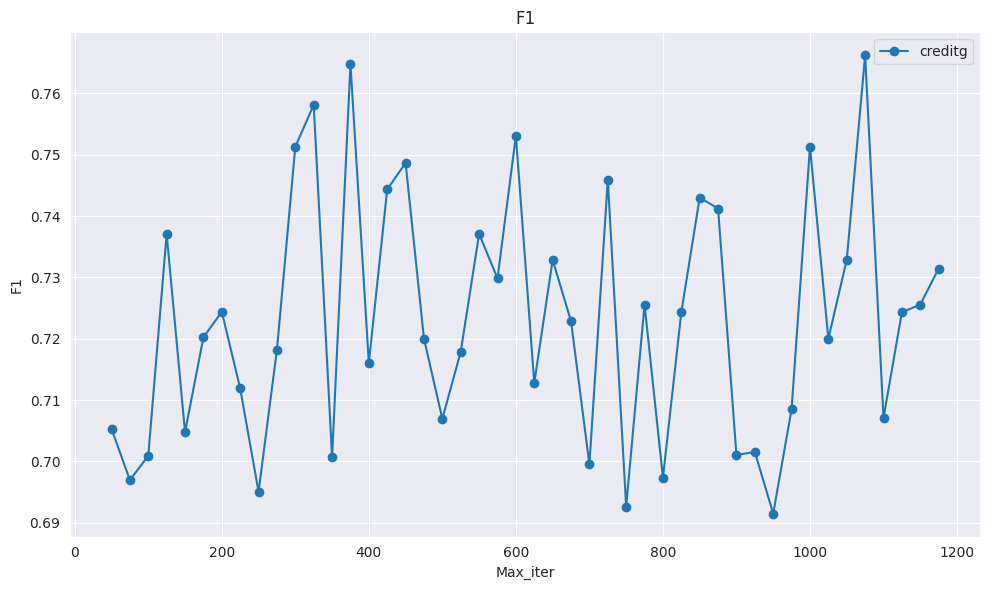

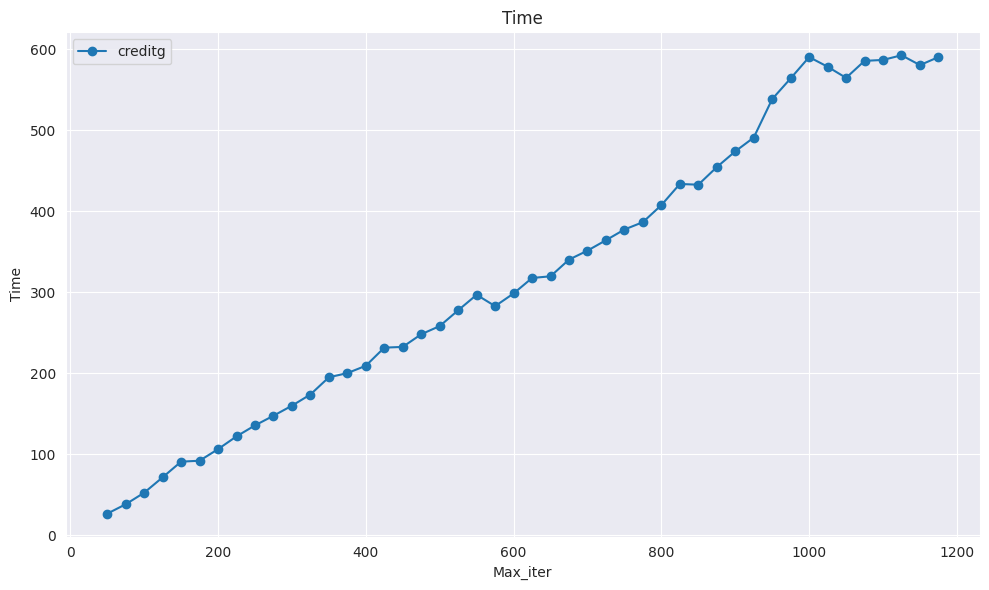

In [32]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-3,
    'hidden_layer_sizes': (7,),
    #'random_state': 7895,
    #'max_iter': 800,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'max_iter': range(50, 1200, 25)}
nn_max_iter = evaluator.evaluate2(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"creditg": nn_max_iter}, x_axis='max_iter', y_axis=['f1', 'time'], logaritmic=False)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (7,), 'max_iter': 3000, 'verbose': False}
done with  activation   identity  results:  {'accuracy': 0.7545, 'recall': 0.7545, 'precision': 0.7412424626009898, 'f1': 0.7432832581887985, 'time': 105.27806282043457, 'activation': 'identity'}
done with  activation   logistic  results:  {'accuracy': 0.737, 'recall': 0.7370000000000001, 'precision': 0.7229095301471558, 'f1': 0.7262814170591827, 'time': 212.21425533294678, 'activation': 'logistic'}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  activation   tanh  results:  {'accuracy': 0.683, 'recall': 0.683, 'precision': 0.6885609022873697, 'f1': 0.6849208228669761, 'time': 1302.5582075119019, 'activation': 'tanh'}
done with  activation   relu  results:  {'accuracy': 0.7245, 'recall': 0.7244999999999999, 'precision': 0.7224313037289009, 'f1': 0.7226119563896574, 'time': 809.1318845748901, 'activation': 'relu'}


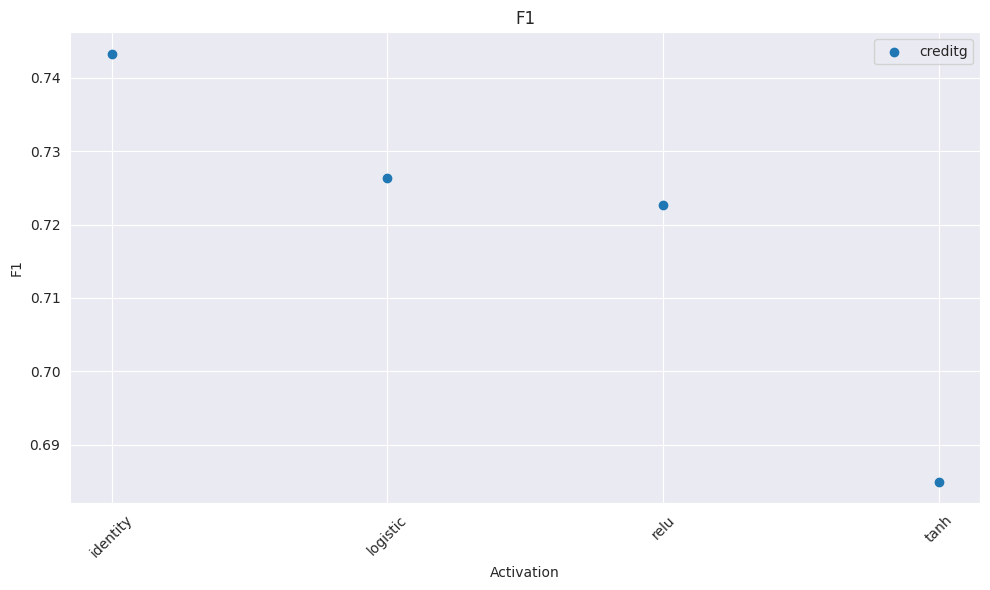

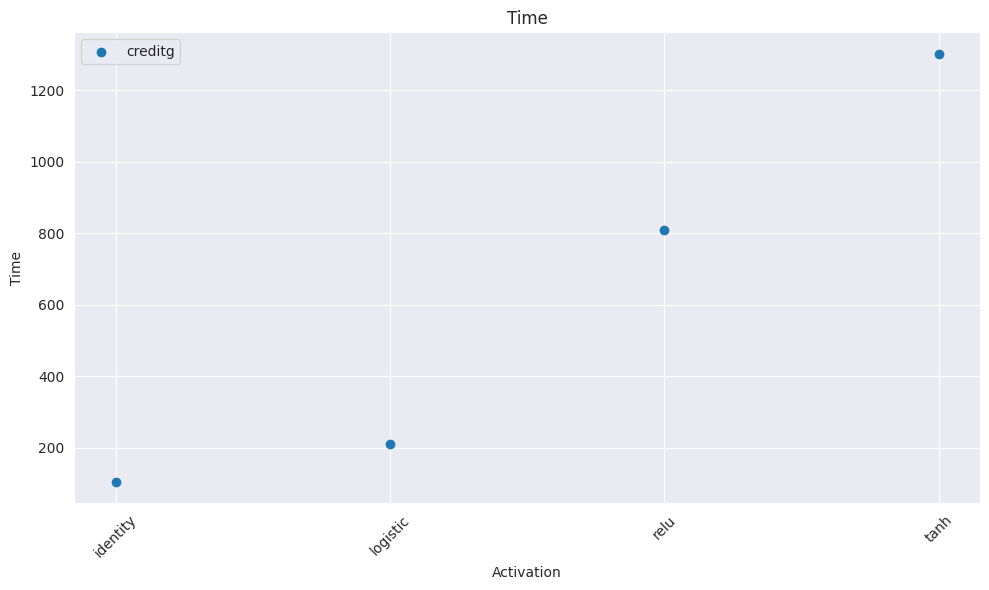

In [49]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    #'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-3,
    'hidden_layer_sizes': (7,),
    #'random_state': 7895,
    'max_iter': 3000,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'activation': ['identity', 'logistic', 'tanh', 'relu']}
act_function1 = evaluator.evaluate2_mean(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                                    hyperparameters_iterate=hyperparameters_iterator, number_of_tests=10)
evaluator.draw_diagram2_list({"creditg": act_function1,},
                             x_axis='activation', y_axis=['f1', 'time'],
                             logaritmic=False, line=False)

## Random Forest

Evaluating classifier:  RandomForestClassifier
Hyperparameters:  {'criterion': 'gini', 'verbose': False}
done with  n_estimators   1  results:  {'accuracy': 0.652, 'recall': 0.652, 'precision': 0.6565055794448358, 'f1': 0.6536879409832851, 'time': 1.660919189453125, 'n_estimators': 1}
done with  n_estimators   2  results:  {'accuracy': 0.621, 'recall': 0.6210000000000001, 'precision': 0.6925500475586549, 'f1': 0.6373472103035699, 'time': 2.4063587188720703, 'n_estimators': 2}
done with  n_estimators   3  results:  {'accuracy': 0.705, 'recall': 0.705, 'precision': 0.6983561145380215, 'f1': 0.7002650862223052, 'time': 3.4059524536132812, 'n_estimators': 3}
done with  n_estimators   4  results:  {'accuracy': 0.654, 'recall': 0.6539999999999999, 'precision': 0.6840175098237473, 'f1': 0.6644272813770075, 'time': 4.515886306762695, 'n_estimators': 4}
done with  n_estimators   5  results:  {'accuracy': 0.72, 'recall': 0.72, 'precision': 0.7015207255367333, 'f1': 0.7061474444814227, 'time': 5.

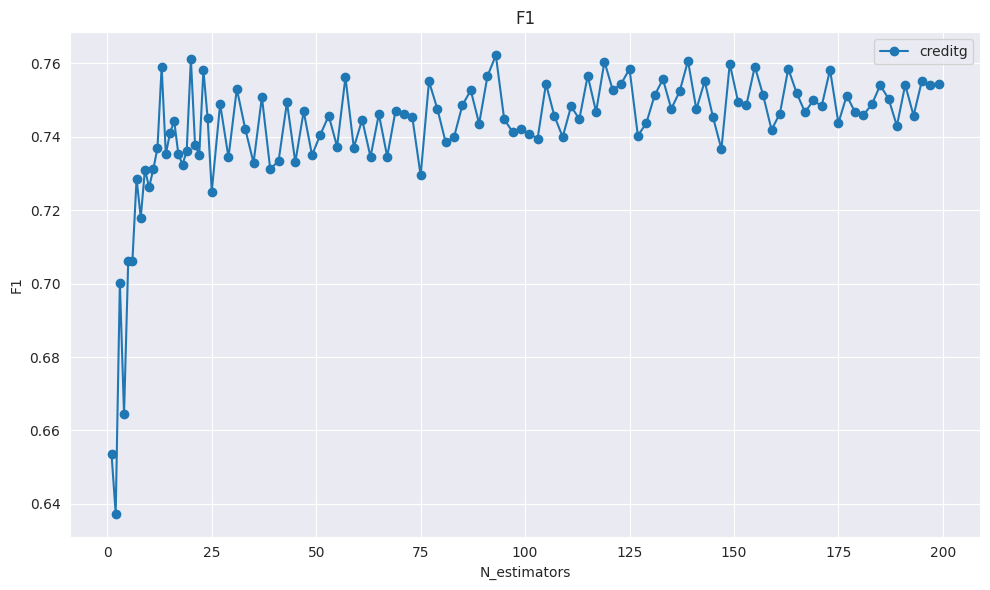

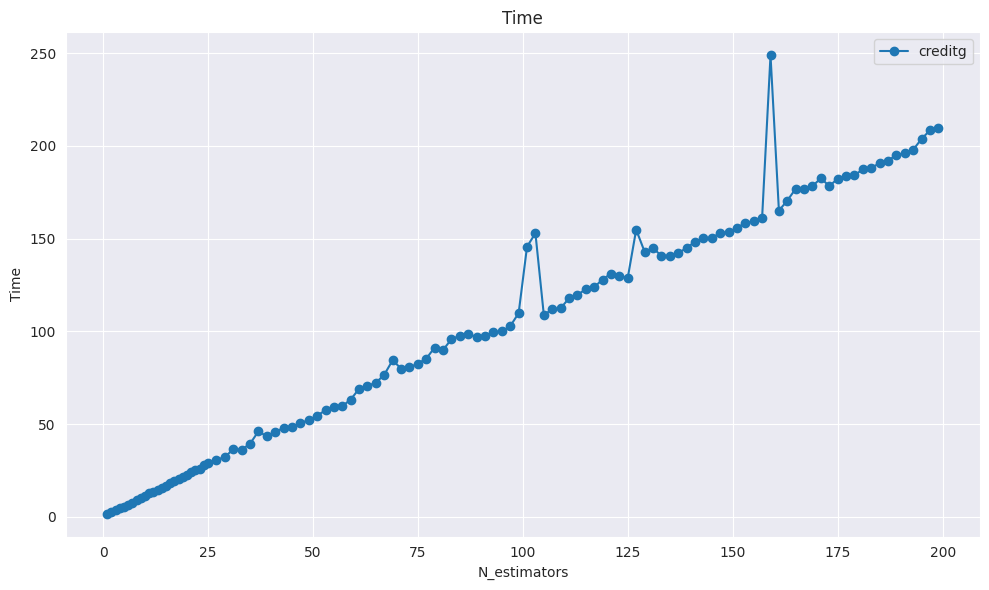

In [51]:
from itertools import chain

hyperparameters = {
    #'n_estimators': 100,
    'criterion': 'gini', # entropy, log_loss
    'verbose': False,
}
hyperparameters_iterator = {'n_estimators': chain(range(1, 25, 1), range(25, 200, 2))}
rf_n_estimators = evaluator.evaluate2_mean(RandomForestClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=5)
evaluator.draw_diagram2_list({"creditg": rf_n_estimators}, x_axis='n_estimators', y_axis=['f1', 'time'], logaritmic=False)

Evaluating classifier:  RandomForestClassifier
Hyperparameters:  {'n_estimators': 5, 'verbose': False}
done with  criterion   gini  results:  {'accuracy': 0.7234999999999999, 'recall': 0.7235, 'precision': 0.7093298471213102, 'f1': 0.7125507264354316, 'time': 6.449098587036133, 'criterion': 'gini'}
done with  criterion   entropy  results:  {'accuracy': 0.7283499999999999, 'recall': 0.72835, 'precision': 0.7146950243914542, 'f1': 0.7178968901626022, 'time': 5.9551239013671875, 'criterion': 'entropy'}
done with  criterion   log_loss  results:  {'accuracy': 0.7304999999999999, 'recall': 0.7304999999999998, 'precision': 0.7157053498036552, 'f1': 0.7189291809017665, 'time': 5.810098648071289, 'criterion': 'log_loss'}


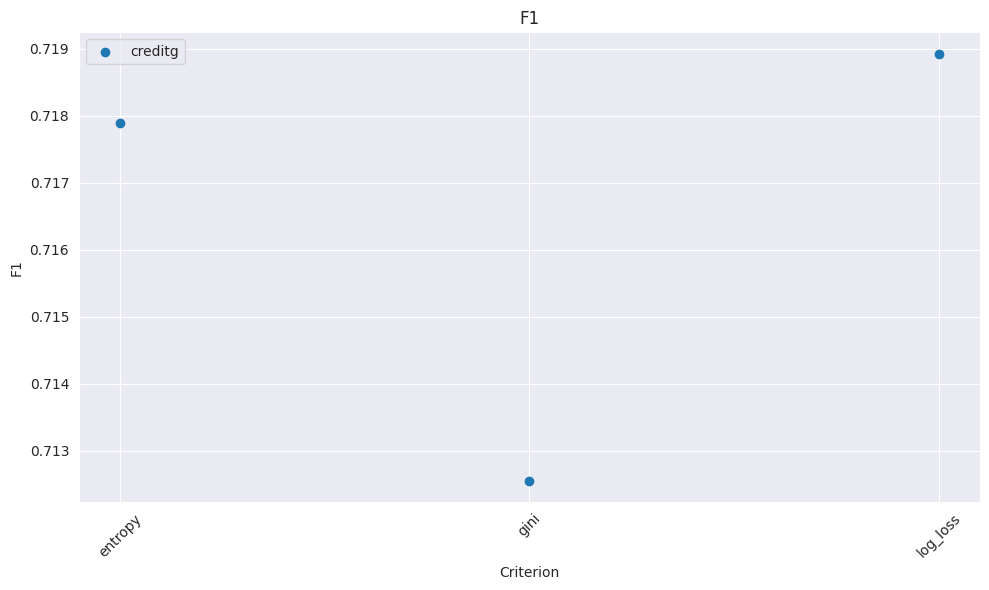

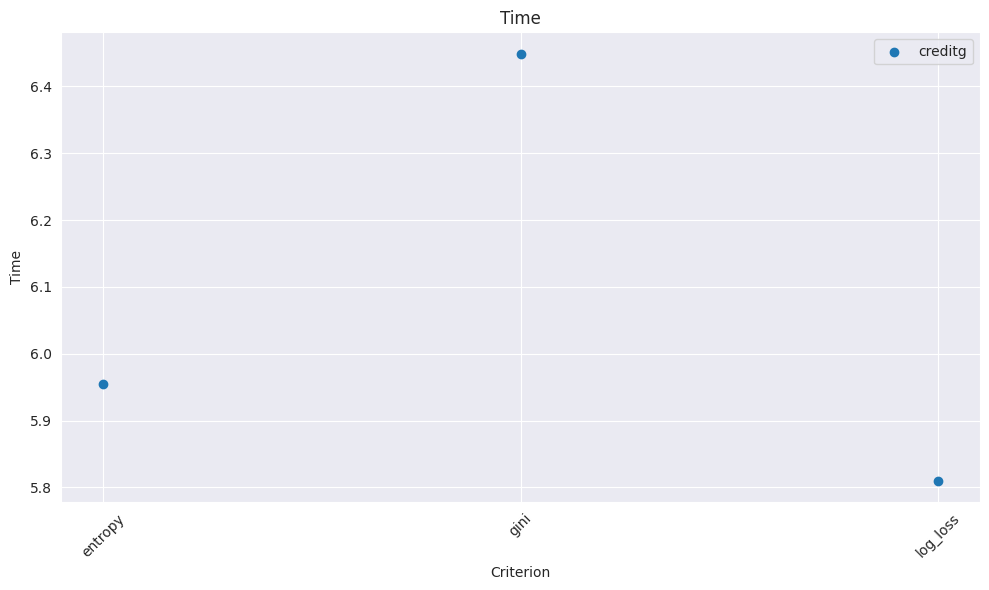

In [55]:
reload(evaluator)
hyperparameters = {
    'n_estimators': 5,
    #'criterion': 'gini', # entropy, log_loss
    'verbose': False,
}
hyperparameters_iterator = {'criterion': ['gini', 'entropy', 'log_loss']}
rf_criterion = evaluator.evaluate2_mean(RandomForestClassifier, X_train, y_train, X_test, y_test,
                                        hyperparameters=hyperparameters,
                                        hyperparameters_iterate=hyperparameters_iterator, number_of_tests=100)

evaluator.draw_diagram2_list({"creditg": rf_criterion, }, x_axis='criterion', y_axis=['f1', 'time'], logaritmic=False,
                             line=False)

## Bayes

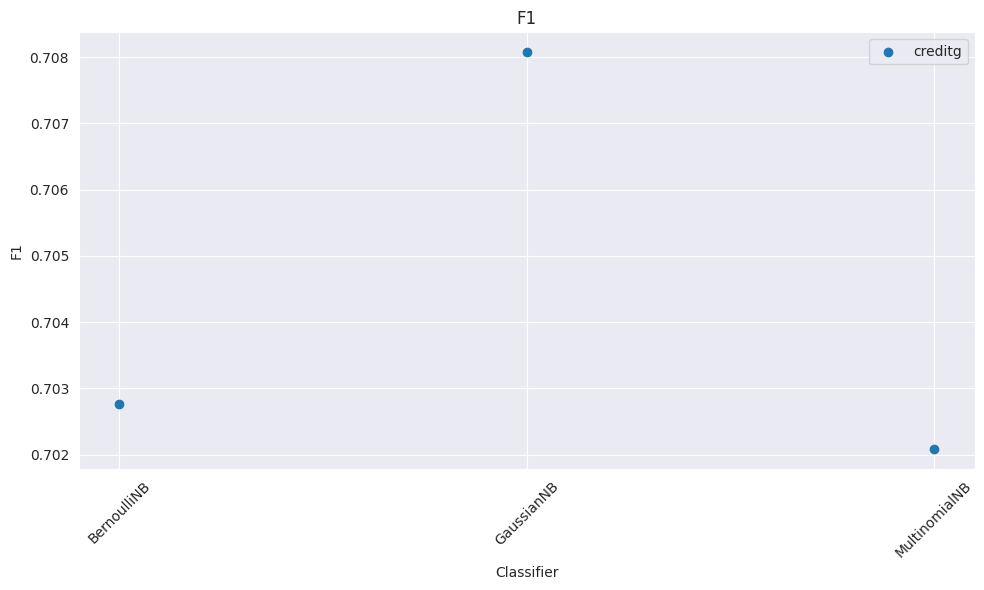

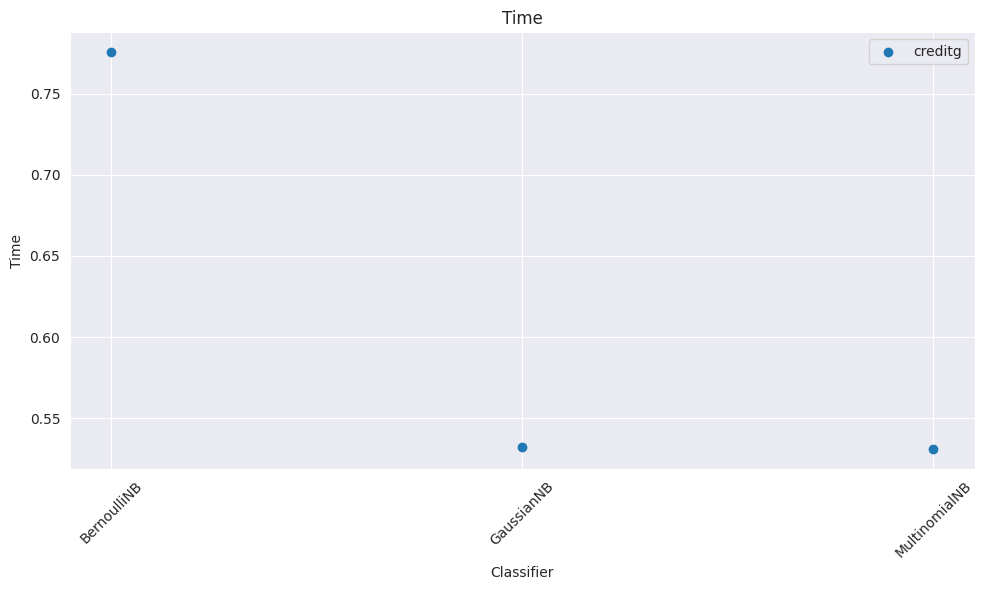

In [56]:
reload(evaluator)

classifiers = [GaussianNB, MultinomialNB, BernoulliNB]
names = ['GaussianNB', 'MultinomialNB', 'BernoulliNB']

bayes_results=evaluator.evaluate_classifier(classifiers, X_train, y_train, X_test, y_test, hyperparameters=[{},{},{},], names=names, number_of_tests=20)
evaluator.draw_diagram2_list({"creditg": bayes_results}, x_axis='classifier', y_axis=['f1', 'time'], logaritmic=False, line=False)

## evaluate scalers

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (7,), 'max_iter': 2500, 'verbose': False}


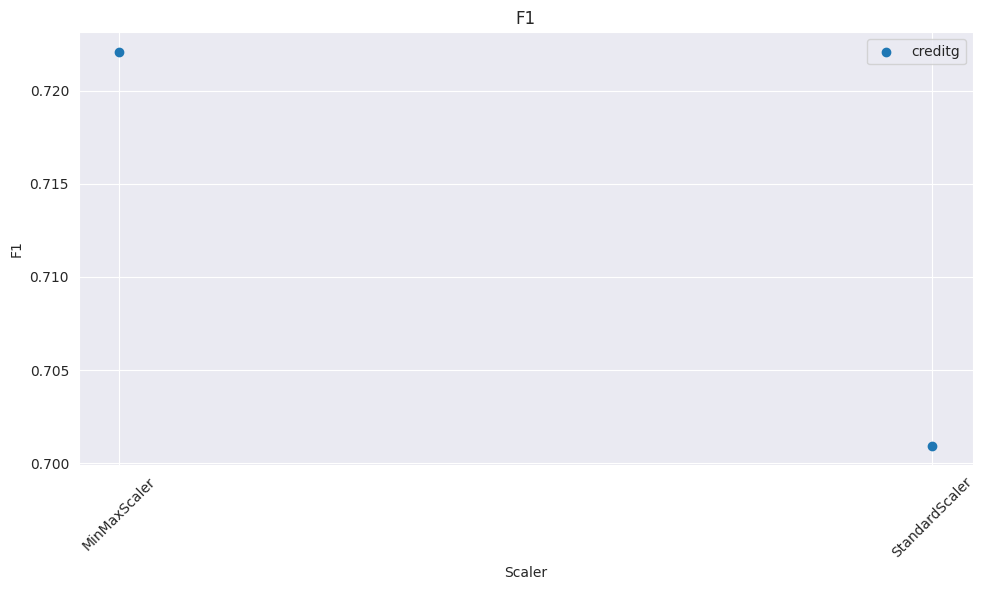

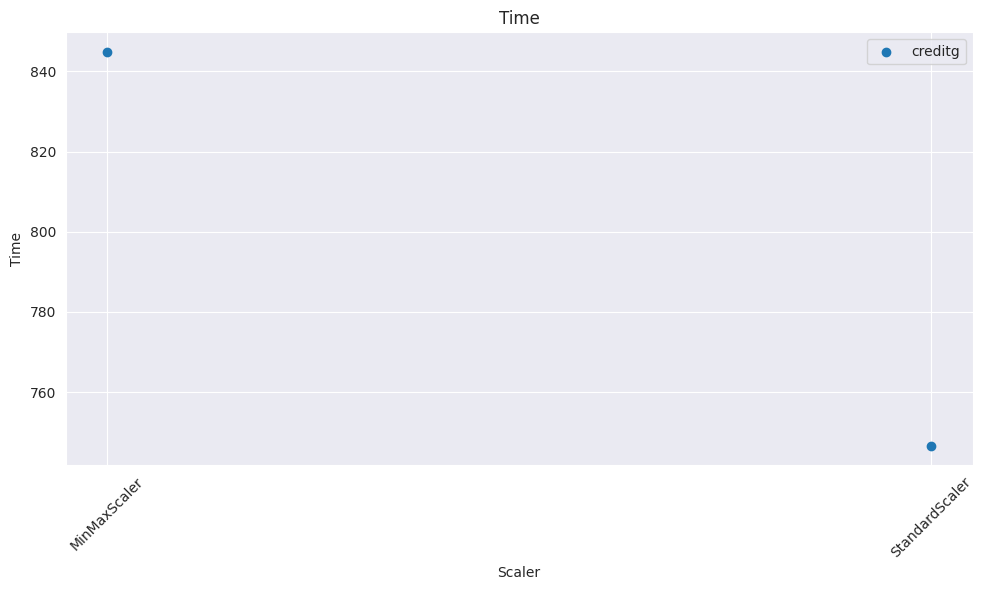

In [59]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-3,
    'hidden_layer_sizes': (7, ),
    #'random_state': 7895,
    'max_iter': 2500,
    'verbose': False,
    #'tol': 5e-5
}

scaler_result=evaluator.evaluate_scaler(MLPClassifier, X_train=[X_train, X_train_std], y_train=[y_train, y_train], X_test=[X_test, X_test_std], y_test=[y_test, y_test], hyperparameters=hyperparameters, names=['MinMaxScaler', 'StandardScaler'], number_of_tests=10)
evaluator.draw_diagram2_list({"creditg": scaler_result}, x_axis='scaler', y_axis=['f1', 'time'], logaritmic=False, line=False)

In [62]:
combined_results_creditg = {
    # NN
    'nn_learning_rate': nn_learning_rate,
    'nn_hidden_layer': nn_hidden_layer,
    'nn_max_iter': nn_max_iter,
    'nn_hidden_layer_deep': nn_hidden_layer_deepness,
    'act_function': act_function1,
    # RF
    'rf_n_estimators': rf_n_estimators,
    'rf_criterion': rf_criterion,
    # Bayes
    'bayes_results': bayes_results,
    'scaler_result': scaler_result
}
import pickle
with open('creditg_results.pkl', 'wb') as f:
    pickle.dump(combined_results_creditg, f)